In [1]:
import matplotlib

import logging
import torch

from data.data_loader import Dataset
from data.germeval2017 import germeval2017_dataset

from misc.preferences import PREFERENCES
from misc.visualizer import *
from misc.run_configuration import get_default_params
from misc import utils

from optimizer import get_default_optimizer
from criterion import NllLoss, LossCombiner

from models.transformer.encoder import TransformerEncoder
from models.softmax_output import SoftmaxOutputLayerWithCommentWiseClass
from models.transformer_tagger import TransformerTagger
from models.jointAspectTagger import JointAspectTagger
from models.transformer.train import Trainer

C:\Users\felix\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
experiment_name = 'JointAspectTest'
use_cuda = True

In [3]:
utils.get_current_git_commit()

"b'6239e35'"

In [4]:
PREFERENCES.defaults(
    data_root='./data/germeval2017',
    data_train='train_v1.4.tsv',    
    data_validation='dev_v1.4.tsv',
    data_test='test_TIMESTAMP1.tsv',
    early_stopping='highest_5_F1'
)

hyperparameters = get_default_params()
hyperparameters.model_size = 300
hyperparameters.batch_size = 12
hyperparameters.num_encoder_blocks = 3
hyperparameters.n_heads = 6
hyperparameters.d_k = 50
hyperparameters.d_v = 50

hyperparameters.early_stopping = 5
hyperparameters.use_cuda = use_cuda
hyperparameters.language = 'de'
hyperparameters.num_epochs = 25
hyperparameters.log_every_xth_iteration = 500
hyperparameters.embedding_type = 'fasttext'

experiment_name = utils.create_loggers(experiment_name=experiment_name)

Log path is  C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\logs\JointAspectTest


In [5]:
dataset = Dataset(
    'germeval',
    logging.getLogger('data_loaoder'),
    hyperparameters,
    source_index=0,
    target_vocab_index=2,
    data_path=PREFERENCES.data_root,
    train_file=PREFERENCES.data_train,
    valid_file=PREFERENCES.data_validation,
    test_file=PREFERENCES.data_test,
    file_format='.tsv',
    init_token=None,
    eos_token=None
)
dataset.load_data(germeval2017_dataset)

A Jupyter Widget


Trying to save loaded dataset to C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\data\cache\train_v1.pkl.
Model train_v1 successfully saved.


A Jupyter Widget


Trying to save loaded dataset to C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\data\cache\dev_v1.pkl.
Model dev_v1 successfully saved.


A Jupyter Widget


Trying to save loaded dataset to C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\data\cache\test_TIMESTAMP1.pkl.
Model test_TIMESTAMP1 successfully saved.
+-------------------------+
|  GERM EVAL 2017 DATASET |
+---------------+---------+
|     Split     |   Size  |
+---------------+---------+
|     train     |  17043  |
|   validation  |   2049  |
|      test     |   2095  |
+---------------+---------+
+--------------------------------------+
|           Vocabulary Stats           |
+------------------------------+-------+
|          Vocabulary          |  Size |
+------------------------------+-------+
|           comments           | 67041 |
|      general_sentiments      |   3   |
|      aspect_sentiments       |   4   |
|           padding            | 23197 |
|   Komfort_und_Ausstattung    |   4   |
|        Informationen         |   4   |
|            Design            |   4   |
|            Image             |   4   |
|       Barrierefreiheit   

In [6]:
print(dataset.class_weights)
print(dataset.class_labels)

[[0.009345353282673385, 0.9944777457875112, 0.997734459810261, 0.9984424411195545], [0.019917874168121963, 0.9865483551234248, 0.995940907160051, 0.9975928635484024], [0.0018407514041629547, 0.999103223674895, 0.9991504224288479, 0.9999056024920943], [0.002737527729267941, 0.9983952423656015, 0.9993392174446595, 0.9995280124604711], [0.004247887855760579, 0.9974512672865437, 0.999056024920942, 0.9992448199367536], [0.08042667673573423, 0.9253315712465191, 0.9965544909614387, 0.9976872610563081], [0.0026431302213622, 0.9980648510879313, 0.9993864161986123, 0.9999056024920943], [0.41907773634776047, 0.7085004955869165, 0.9092839949025345, 0.9631377731627885], [0.011138905932883358, 0.993675366970312, 0.9971208760088733, 0.9980648510879313], [0.0010855713409165801, 0.9994336149525652, 0.9995280124604711, 0.9999528012460471], [0.002595931467409218, 0.9985840373814131, 0.9991976211828008, 0.9996224099683768], [0.014914806249115009, 0.9907018454712796, 0.9967432859772501, 0.9976400623023552]

In [7]:
loss = LossCombiner(4, dataset.class_weights, NllLoss)
transformer = TransformerEncoder(dataset.source_embedding,
                                 hyperparameters=hyperparameters)
tagging_softmax = SoftmaxOutputLayerWithCommentWiseClass(hyperparameters.model_size, dataset.target_size)
model = JointAspectTagger(transformer, hyperparameters.model_size, 4, 20, dataset.target_names)


pre_training - DEBUG - 20 initialized
pre_training - DEBUG - Initilize parameters with nn.init.xavier_uniform_
pre_training - DEBUG - Tagger initialized


In [8]:
hyperparameters.num_epochs = 25

optimizer = get_default_optimizer(model, hyperparameters)
trainer = Trainer(
                    model,
                    loss,
                    optimizer,
                    hyperparameters,
                    dataset,
                    experiment_name,
                    enable_tensorboard=True)

pre_training - INFO - JointAspectTagger (
  (encoder): TransformerEncoder(
    (src_embeddings): Embedding(67041, 300)
    (positional_encoding): PositionalEncoding2(
      (dropout): Dropout(p=0.1)
    )
    (encoder_blocks): ModuleList(
      (0): EncoderBlock(
        (self_attention_layer): MultiHeadedSelfAttentionLayer(
          (query_projections): Linear(in_features=300, out_features=300, bias=False)
          (key_projections): Linear(in_features=300, out_features=300, bias=False)
          (value_projections): Linear(in_features=300, out_features=300, bias=False)
          (attention_layer): ScaledDotProductAttentionLayer(
            (dropout): Dropout(p=0.1)
          )
          (layer_norm): LayerNorm()
          (w_0): Linear(in_features=300, out_features=300, bias=False)
          (dropout): Dropout(p=0.1)
        )
        (feed_forward_layer): PointWiseFCLayer(
          (layer_norm): LayerNorm()
          (w_1): Linear(in_features=300, out_features=2048, bias=True)
 

SoftmaxOutputLayerWithCommentWiseClass-36                    [-1, 4]               0
           Linear-37                [-1, 42, 4]           1,204
SoftmaxOutputLayerWithCommentWiseClass-38                    [-1, 4]               0
           Linear-39                [-1, 42, 4]           1,204
SoftmaxOutputLayerWithCommentWiseClass-40                    [-1, 4]               0
           Linear-41                [-1, 42, 4]           1,204
SoftmaxOutputLayerWithCommentWiseClass-42                    [-1, 4]               0
           Linear-43                [-1, 42, 4]           1,204
SoftmaxOutputLayerWithCommentWiseClass-44                    [-1, 4]               0
           Linear-45                [-1, 42, 4]           1,204
SoftmaxOutputLayerWithCommentWiseClass-46                    [-1, 4]               0
           Linear-47                [-1, 42, 4]           1,204
SoftmaxOutputLayerWithCommentWiseClass-48                    [-1, 4]               0
           Linear-49 


pre_training - INFO - Classes: ['n/a', 'neutral', 'negative', 'positive']
pre_training - INFO - Tensorboard enabled. Run will be located at /runs/JointAspectTest/20190212/25/0/. Full path is C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\runs\JointAspectTest\20190212\25EP\0


In [10]:
#trainer.load_model()
result = trainer.train(use_cuda=hyperparameters.use_cuda, perform_evaluation=False)

pre_training - DEBUG - train with cuda support
pre_training - INFO - 1421 Iterations per epoch with batch size of 12
pre_training - INFO - Total iterations: 35525
pre_training - INFO - START training.





A Jupyter Widget

# EP	# IT	tr loss		val loss	f1		acc		duration / total time
1	500	264.56		139.12		0.827		0.827		0.00m - 1.0m / 0.0m
1	1000	132.48		98.50		0.916		0.916		0.00m - 2.3m / 0.0m
1	1421	174.96		23.99		0.875		0.875		5.68m - 5.7m / 0.0m
2	1500	116.43		77.48		0.823		0.823		5.68m - 5.8m / 142.0m
2	2000	101.35		100.78		0.891		0.891		5.68m - 7.1m / 142.0m
2	2500	97.93		80.51		0.794		0.794		5.68m - 8.3m / 142.0m
2	2842	95.94		19.45		0.826		0.826		5.59m - 11.3m / 142.0m
3	3000	81.87		64.66		0.900		0.900		5.59m - 11.6m / 139.8m
3	3500	75.97		61.34		0.886		0.886		5.59m - 12.8m / 139.8m
3	4000	59.19		53.70		0.912		0.912		5.59m - 14.0m / 139.8m
3	4263	65.39		8.75		0.886		0.886		5.54m - 16.8m / 139.8m
4	4500	49.00		51.27		0.890		0.890		5.54m - 17.3m / 138.7m
4	5000	44.05		35.99		0.897		0.897		5.54m - 18.5m / 138.7m
4	5500	32.98		25.49		0.837		0.837		5.54m - 19.7m / 138.7m
4	5684	37.70		6.79		0.920		0.920		5.49m - 22.3m / 138.7m
5	6000	15.01		14.46		0.914		0.914		5.49m - 23.1m / 137.8m
5	6500	8.38		11.11		0

In [9]:
plt.rcParams['figure.figsize'] = [15, 15]

In [ ]:
model = result['model']

In [ ]:
result_labels = trainer.classify_sentence('I was born in 1993 in Stuttgart')



print(result_labels)

In [ ]:
tr = trainer.text_reverser[1]
lr = trainer.label_reverser

test_sentence = ['china', 'controlled', 'most', 'of', 'the', 'match']
test_sentence

In [ ]:
test_sentence = tr.preprocess('Die Bahn ist nicht gut')

#test_sentence = tr.preprocess('china controlled most of the match on 1993')
test_sentence = [x.strip(' ') for x in test_sentence]
test_sentence = [test_sentence]
test_sentence

In [ ]:

#test = tr.preprocess('china controlled most of the match')
#print(test)

#test_sentence = [['china', 'controlled', 'most', 'of', 'the', 'match']]
x = tr.process(test_sentence)

print("X TENSOR ",x)
print('X Size', x.size())
print("Reversed X", tr.reverse(x))
x = x.cuda()
y_hat = model.predict(x)
y_hat_label = lr.reverse(y_hat)
print(y_hat_label)



pre_training - INFO - Perform final model evaluation
pre_training - DEBUG - --- Train Scores ---


A Jupyter Widget

pre_training - INFO - TRAIN loss:	2.6783498203811837
pre_training - INFO - TRAIN f1-s:	0.9771753799213754
pre_training - INFO - TRAIN accuracy:	0.9771753799213754
pre_training - DEBUG - --- Valid Scores ---


A Jupyter Widget

pre_training - INFO - VALID loss:	8.001406143626225
pre_training - INFO - VALID f1-s:	0.9250122010736945
pre_training - INFO - VALID accuracy:	0.9250122010736945


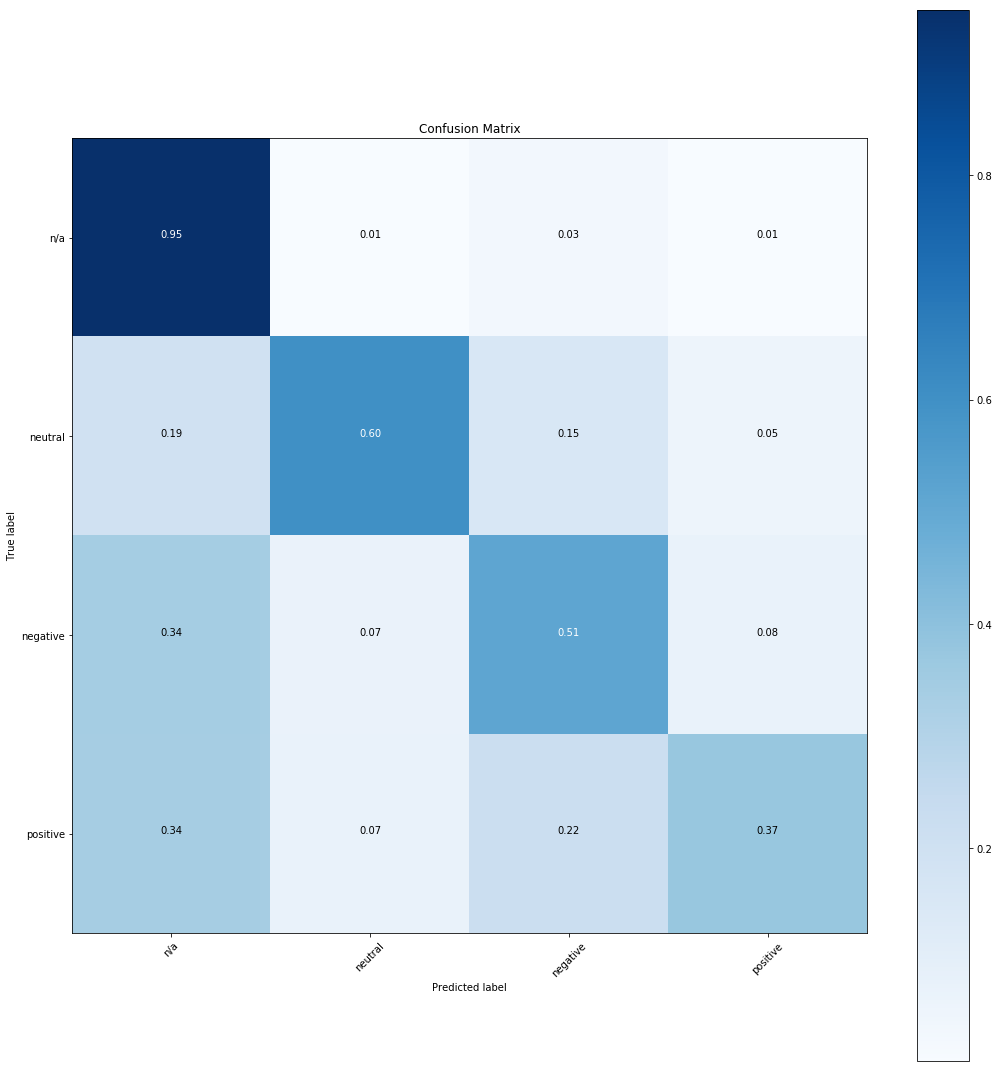

A Jupyter Widget

pre_training - INFO - TEST loss:	8.16391949563919
pre_training - INFO - TEST f1-s:	0.9210262529832935
pre_training - INFO - TEST accuracy:	0.9210262529832935


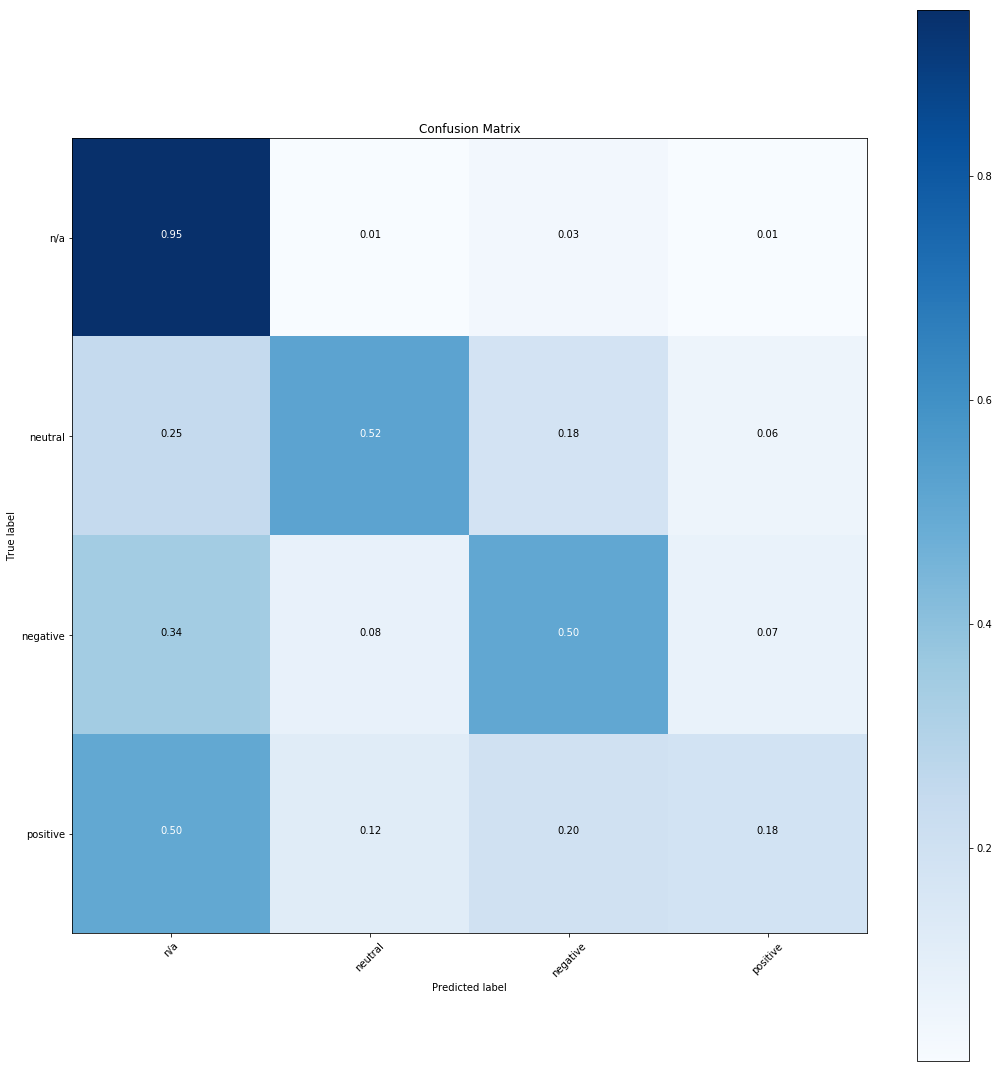

In [11]:
trainer.tb_writer = None
trainer.enable_tensorboard = False
evaluation_results = trainer.perform_final_evaluation()

In [ ]:
c_matrix = evaluation_results[1][2]
c_matrix

In [ ]:
fig = plot_confusion_matrix(c_matrix, class_labels)
plt.show()

In [ ]:
fig = plot_confusion_matrix(c_matrix, dataset.class_labels, normalize=True)
plt.show()

In [ ]:
# predict now to see model in final state
from IPython.display import display, HTML

df = predict_some_examples_to_df(model, conll2003['iters'][2], num_samples=800)
display(HTML(df.to_html()))

In [ ]:
df = predict_some_examples_to_df(model, conll2003['iters'][1], num_samples=800)
display(HTML(df.to_html()))

In [ ]:
df = predict_some_examples_to_df(model, conll2003['iters'][0], num_samples=800)
display(HTML(df.to_html()))

In [ ]:
import numpy as np
a = np.array([
    np.array([[1, 1], [1, 1]]),
    np.array([[2, 2], [-2, -3]])
])
print(a)

In [ ]:
a.sum(axis=0)

In [ ]:
#df = predict_some_examples_to_df(model, test_sample_iter)
#print(df)

In [ ]:
#print(result)

In [ ]:
(tr_loss, tr_f1) = result['result_train']
